In [4]:
import torch
from torch_geometric.loader import DataLoader
import torch_geometric
import logging
import os
from detanet_model import *

import wandb

batch_size = 8
epochs = 20
lr=5e-4

wandb.init(
    # set the wandb project where this run will be logged
    project="static_polarizability",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "GNN",
    "dataset": "HarvardOPV",
    "epochs": epochs,
    }
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = DetaNet(num_features=128,
                    act='swish',
                    maxl=3,
                    num_block=3,
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=8,
                    rc=5.0,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=2, # 2,#4, 
                    irreps_out='2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='2_tensor', # '2_tensor',
                    grad_type=None,
                    device=device)
state_dict = torch.load("/home/maria/dyn-detanet/code/trained_param/hov15_finetuned_static_pol.pth")
model.load_state_dict(state_dict=state_dict)
model.to(device) 
wandb.watch(model, log="all")


In [2]:

'''Next, define the trainer and the parameters used for training.'''
class Trainer:
    def __init__(self,model,train_loader,val_loader=None,loss_function=l2loss,device=torch.device(device),
                 optimizer='Adam_amsgrad',lr=5e-4,weight_decay=0):
        self.opt_type=optimizer
        self.device=device
        self.model=model
        self.train_data=train_loader
        self.val_data=val_loader
        self.device=device
        self.opts={'AdamW':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'AdamW_amsgrad':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adam':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'Adam_amsgrad':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adadelta':torch.optim.Adadelta(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'RMSprop':torch.optim.RMSprop(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'SGD':torch.optim.SGD(self.model.parameters(),lr=lr,weight_decay=weight_decay)
        }
        self.optimizer=self.opts[self.opt_type]
        self.loss_function=loss_function
        self.step=-1
    def train(self,num_train,targ,stop_loss=1e-8, val_per_train=50, print_per_epoch=10):
        self.model.train()
        len_train=len(self.train_data)
        for i in range(num_train):
            val_datas=iter(self.val_data)
            for j,batch in enumerate(self.train_data):
                self.step=self.step+1
                torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                out = self.model(pos=batch.pos.to(self.device), z=batch.z.to(self.device), batch=batch.batch.to(self.device))
                #print("out", out)
                target = batch[targ].to(self.device)

                #print("target," , target)
                loss = self.loss_function(out.reshape(target.shape),target)
                loss.backward()
                self.optimizer.step()
                wandb.log({"train_loss": loss, "epoch": i})
                if (self.step%val_per_train==0) and (self.val_data is not None):
                    val_batch = next(val_datas)
                    val_out = self.model(pos=val_batch.pos.to(self.device), z=val_batch.z.to(self.device), batch=val_batch.batch.to(self.device))
                    val_target=val_batch[targ].to(self.device).reshape(-1)

                    # Ensure the shapes match
                    val_loss = self.loss_function(val_out.reshape(val_target.shape), val_target.to(self.device)).item()
                    val_mae = l1loss(val_out.reshape(val_target.shape), val_target.to(self.device)).item()
                    val_R2 = R2(val_out.reshape(val_target.shape), val_target.to(self.device)).item()
                    wandb.log({"val_loss": val_loss, "epoch": i})
                    wandb.log({"val_mae": val_mae, "epoch": i})
                    wandb.log({"val_R2": val_R2, "epoch": i})

                    if self.step % print_per_epoch==0:
                        print('Epoch[{}/{}],loss:{:.8f},val_loss:{:.8f},val_mae:{:.8f},val_R2:{:.8f}'
                              .format(self.step,num_train*len_train,loss.item(),val_loss,val_mae,val_R2))

                    assert (loss > stop_loss) or (val_loss > stop_loss),'Training and prediction Loss is less' \
                                                                        ' than cut-off Loss, so training stops'
                elif (self.step % print_per_epoch == 0) and (self.step%val_per_train!=0):
                    print('Epoch[{}/{}],loss:{:.8f}'.format(self.step,num_train*len_train, loss.item()))
                    
    def load_state_and_optimizer(self,state_path=None,optimizer_path=None):
        if state_path is not None:
            state_dict=torch.load(state_path)
            self.model.load_state_dict(state_dict)
        if optimizer_path is not None:
            self.optimizer=torch.load(optimizer_path)

    def save_param(self,path):
        torch.save(self.model.state_dict(),path)

    def save_model(self,path):
        torch.save(self.model, path)

    def save_opt(self,path):
        torch.save(self.optimizer,path)

    def params(self):
        return self.model.state_dict()


In [11]:

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

dataset = []

# Load the dataset
dataset = torch.load(os.path.join(data_dir, "HOPV" + '.pt'))
print(f"Number of graphs in the dataset: {len(dataset)}")

print(f"Total dataset length: {len(dataset)}")

ex1 = dataset[0]
ex2 = dataset[5]

print("dataset[0] :", ex1, )
print("dataset[5] :", ex2,)

ref_dataset = []
# No normalization
for data in dataset:
    y = data.real_ee[0]
    freq = data.freqs[0]
    
    #assert freq is zero
    assert freq == 0, "Frequency should be zero for polarizability calculation"

    # Create the dataset entry
    data_entry = torch_geometric.data.Data(
        idx=data.idx,
        pos=data.pos,
        z=torch.LongTensor(data.z),
        y=y      
    )
    ref_dataset.append(data_entry)

train_datasets=[]
val_datasets=[]
for i in range(len(ref_dataset)):
    if i%10==0:
        val_datasets.append(ref_dataset[i])
    else:
        train_datasets.append(ref_dataset[i])

'''Using torch_Geometric.dataloader.DataLoader Converts a dataset into a batch of 64 molecules of training data.'''

trainloader=DataLoader(train_datasets,batch_size=batch_size,shuffle=True)
valloader=DataLoader(val_datasets,batch_size=batch_size,shuffle=True)

'''Finally, using the trainer, training 20 times from a 5e-4 learning rate'''
#trainer=Trainer(model,train_loader=trainloader,val_loader=valloader,loss_function=l2loss,lr=lr,weight_decay=0,optimizer='AdamW')
#trainer.train(num_train=epochs,targ='y')

#torch.save(model.state_dict(), current_dir + '/trained_param/hov15_finetuned.pth')


Number of graphs in the dataset: 347
Total dataset length: 347
dataset[0] : Data(pos=[68, 3], idx='HOPV_0', dataset_name='HOPV', smiles='Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', z=[68], freqs=[62], spectra=[62], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], imag_em=[62, 3, 3], real_mm=[62, 3, 3], imag_mm=[62, 3, 3], osc_pos=[40], osc_strength=[40])
dataset[5] : Data(pos=[55, 3], idx='HOPV_5', dataset_name='HOPV', smiles='C#Cc1cc(OC)c(C#Cc2scc3nc(-c4ccccc4)c(-c4ccccc4)nc32)cc1OC', z=[55], freqs=[62], spectra=[62], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], imag_em=[62, 3, 3], real_mm=[62, 3, 3], imag_mm=[62, 3, 3], osc_pos=[40], osc_strength=[40])


'Finally, using the trainer, training 20 times from a 5e-4 learning rate'

In [12]:
eval_loader = DataLoader(val_datasets, batch_size=1, shuffle=False)

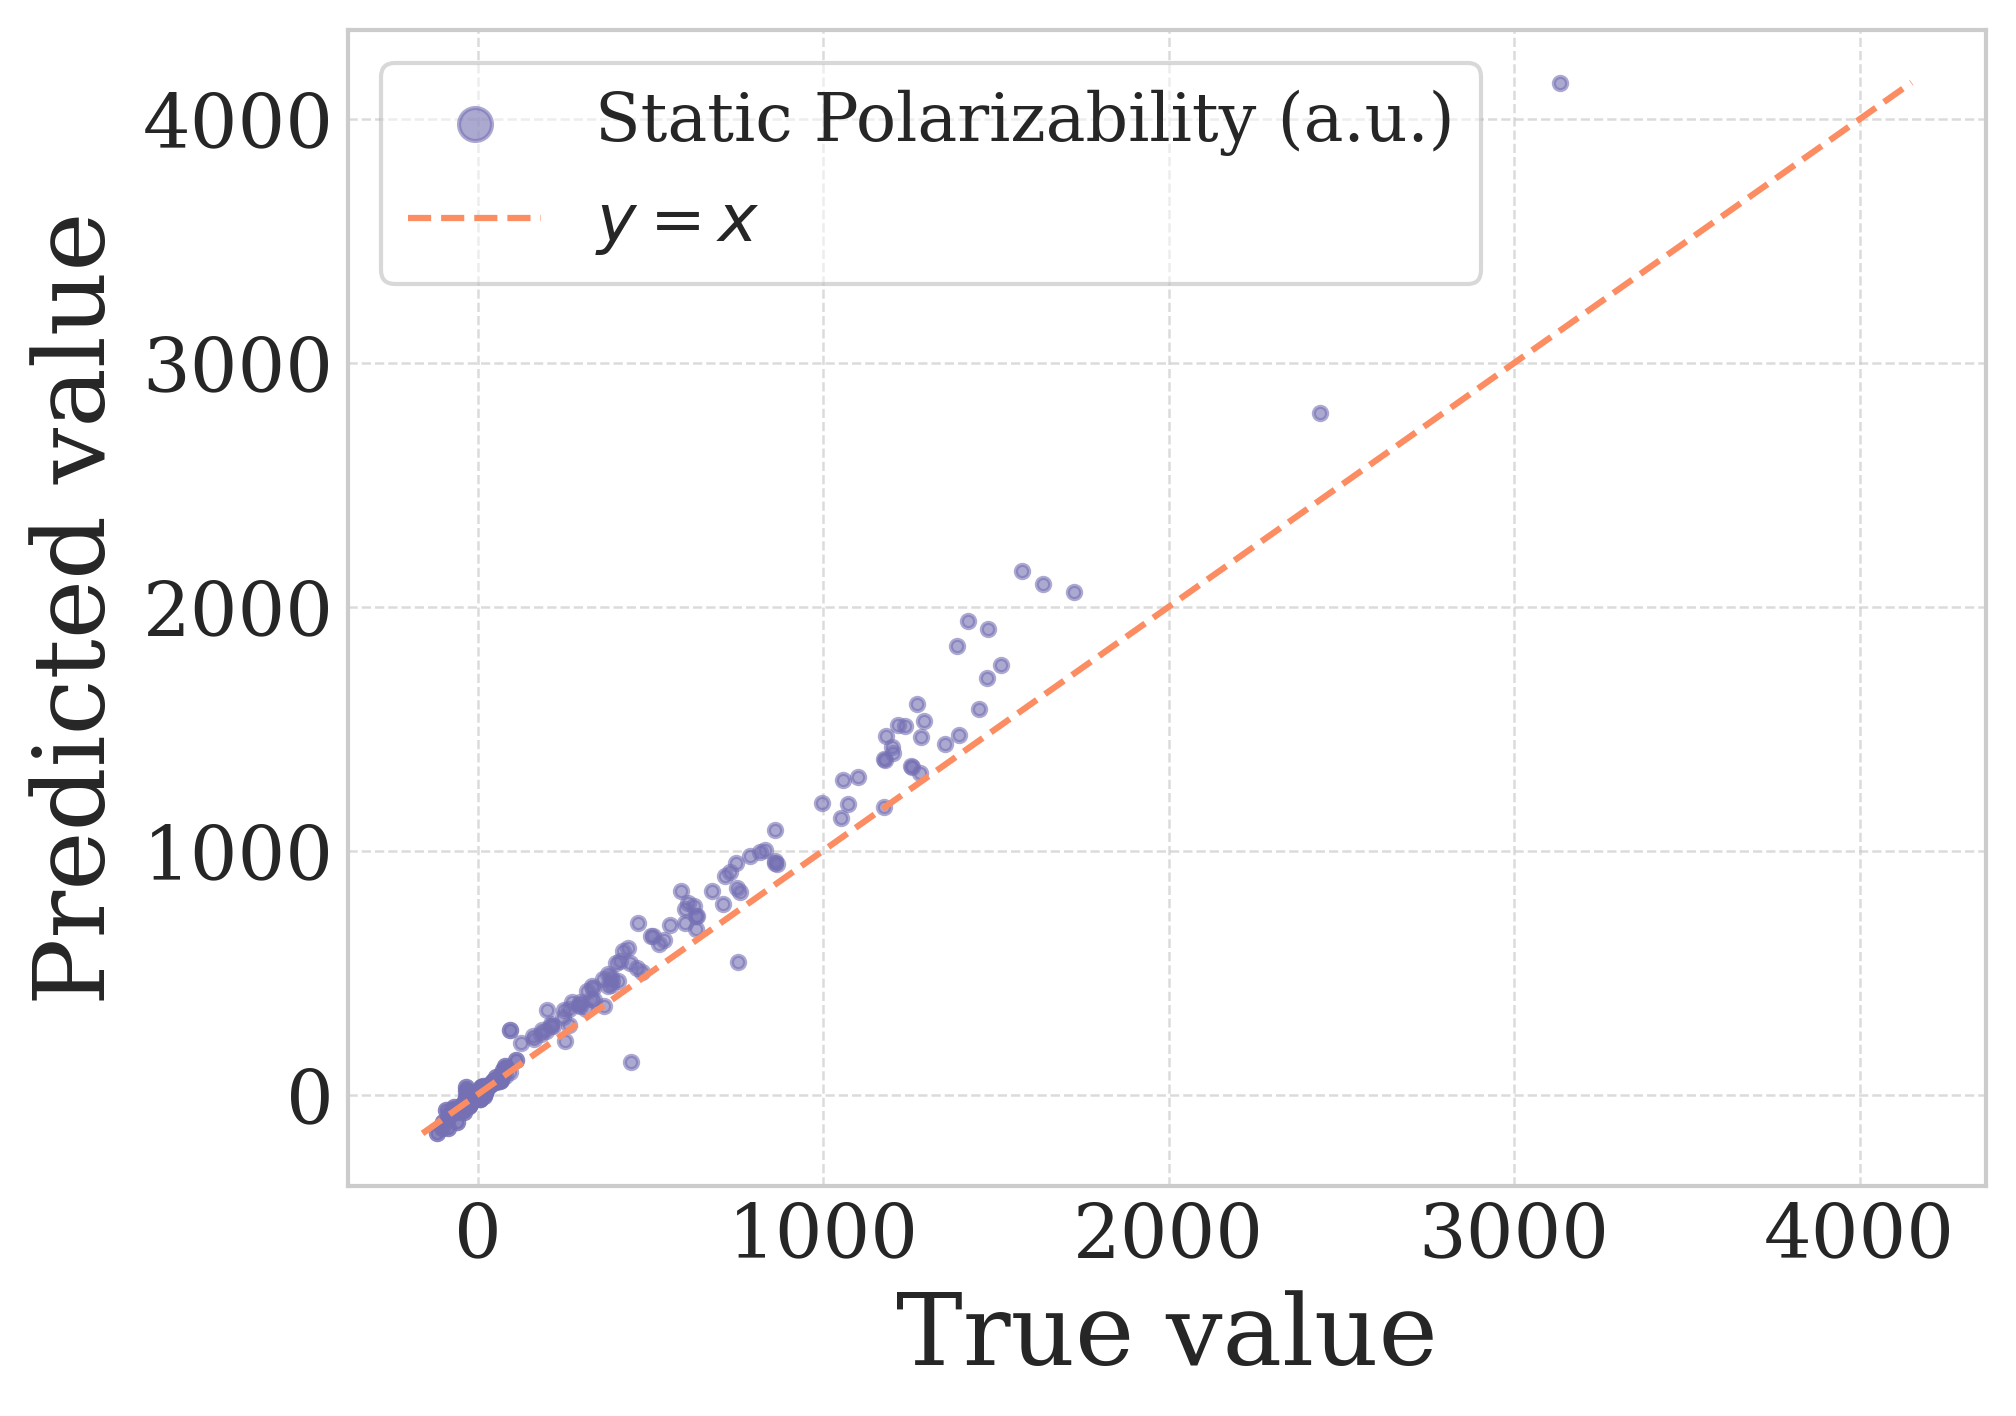

In [16]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.nn import global_mean_pool

# ─────────────────────────────────────────────
# Apply consistent visual styling
# ─────────────────────────────────────────────
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size":        16,
    "axes.labelsize":   24,
    "axes.titlesize":   18,
    "xtick.labelsize":  18,
    "ytick.labelsize":  18,
    "legend.fontsize":  16,
})

# ─────────────────────────────────────────────
# 1. Evaluate the model
# ─────────────────────────────────────────────
predictions, true_values = [], []

model.eval()
with torch.no_grad():
    for batch in eval_loader:  # HOPV15 validation set
        true_values.append(batch.y)  # [batch_size, 1]
        val_out = model(pos=batch.pos.to(device),
                        z=batch.z.to(device),
                        batch=batch.batch.to(device))
        predictions.append(val_out)

true_values = torch.cat(true_values, dim=0).cpu().squeeze()   # [N]
predictions = torch.cat(predictions, dim=0).cpu().squeeze()   # [N]

# ─────────────────────────────────────────────
# 2. Scatter plot
# ─────────────────────────────────────────────
plt.figure(figsize=(7, 5), dpi=300)
plt.scatter(true_values, predictions,
            c="#7570b3", alpha=0.6, s=10, label="Static Polarizability (a.u.)")

vmin, vmax = min(true_values.min(), predictions.min()), max(true_values.max(), predictions.max())
plt.plot([vmin, vmax], [vmin, vmax],
         ls="--", color="#fc8d62", lw=1.5, label="$y = x$")

plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.legend(
    frameon=True,
    facecolor="white",
    edgecolor="0.7",
    framealpha=0.5,
    markerscale=2.5
)
plt.grid(True, ls="--", lw=0.6, alpha=0.7)
plt.tight_layout()
plt.savefig("polarizability_HOPV15_styled.png", bbox_inches="tight")
plt.show()


In [17]:
model_direct = DetaNet(num_features=128,
                    act='swish',
                    maxl=3,
                    num_block=3,
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=8,
                    rc=5.0,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=2, # 2,#4, 
                    irreps_out='2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='2_tensor', # '2_tensor',
                    grad_type=None,
                    device=device)
state_dict = torch.load("/home/maria/dyn-detanet/code/trained_param/hopv_polar_static_pol.pth")
model_direct.load_state_dict(state_dict=state_dict)
model_direct.to(device) 


DetaNet(
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=128, bias=False)
    (nuclare_emb): Embedding(35, 128)
    (ls): Linear(in_features=128, out_features=128, bias=True)
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=128, out_features=128, bias=True)
          (lk): Linear(in_features=128, out_features=128, bias=True)
          (lv): Linear(in_features=128, out_features=256, bias=True)
          (la): Linear(in_features=256, out_features=256, bias=True)
          (lrbf): Linear(in_features=32, out_features=128, bias=False)
          (lkrbf): Linear(in_features=128, out_features=128, bias=False)
          (lvrbf): Linear(in_featu

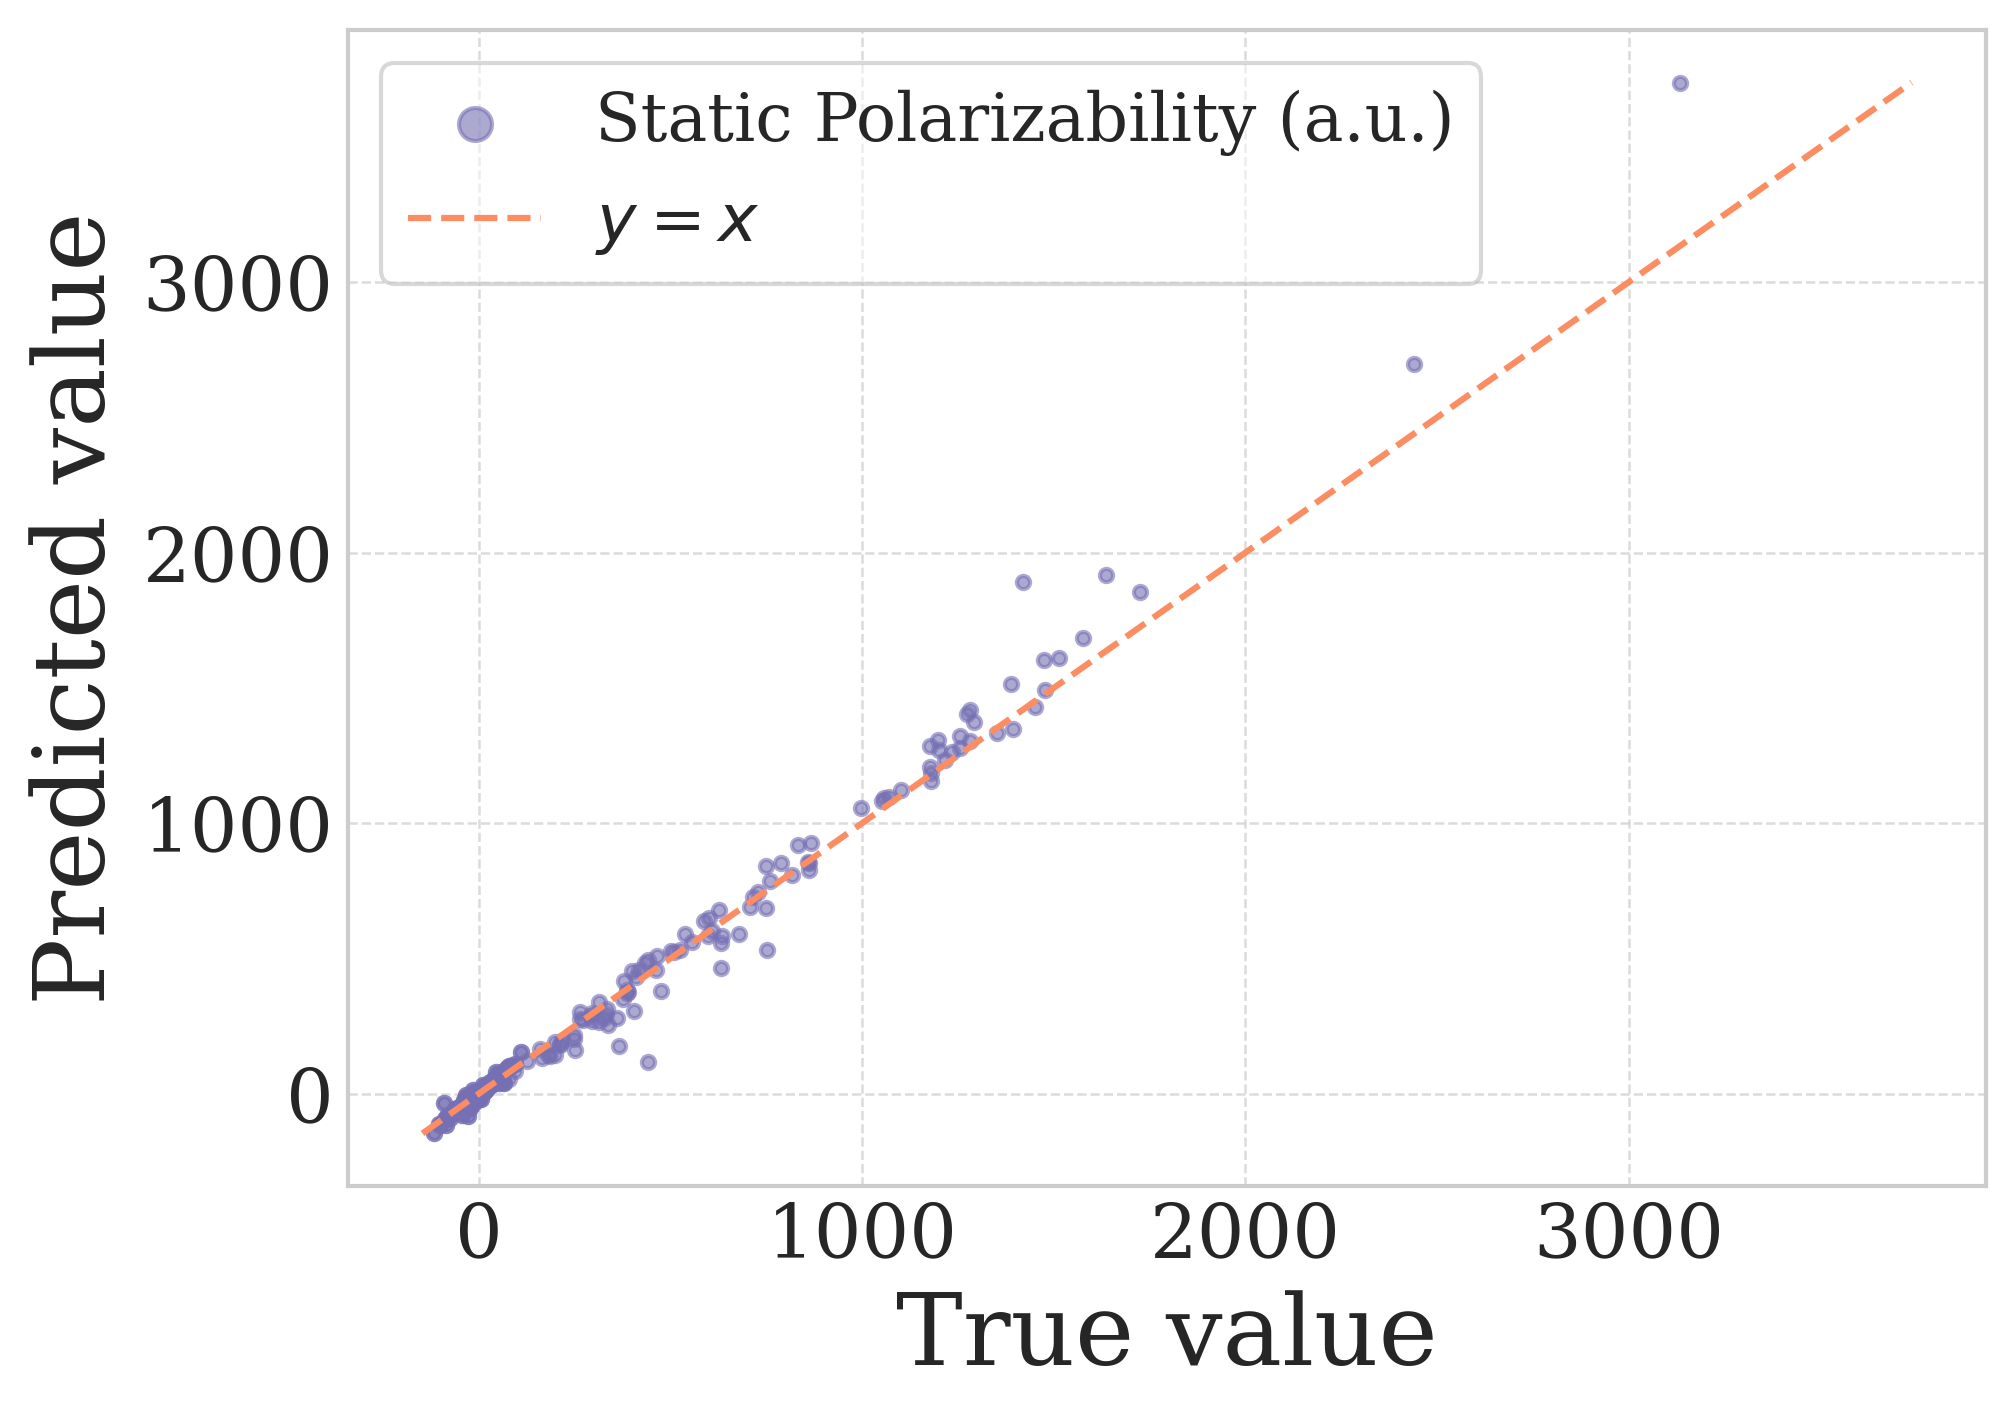

In [20]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import global_mean_pool

# ─────────────────────────────────────────────
# Apply consistent visual styling
# ─────────────────────────────────────────────
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size":        16,
    "axes.labelsize":   24,
    "axes.titlesize":   18,
    "xtick.labelsize":  18,
    "ytick.labelsize":  18,
    "legend.fontsize":  16,
})

# ─────────────────────────────────────────────
# 1. Evaluate model_direct on HOPV15
# ─────────────────────────────────────────────
predictions, true_values = [], []

model_direct.eval()
with torch.no_grad():
    for batch in valloader:
        true_values.append(batch.y)
        val_out = model_direct(pos=batch.pos.to(device),
                               z=batch.z.to(device),
                               batch=batch.batch.to(device))
        predictions.append(val_out)

true_values = torch.cat(true_values, dim=0).cpu().squeeze()
predictions = torch.cat(predictions, dim=0).cpu().squeeze()

# ─────────────────────────────────────────────
# 2. Styled scatter plot
# ─────────────────────────────────────────────
plt.figure(figsize=(7, 5), dpi=300)
plt.scatter(true_values, predictions,
            c="#7570b3", alpha=0.6, s=10, label="Static Polarizability (a.u.)")

vmin = min(true_values.min(), predictions.min())
vmax = max(true_values.max(), predictions.max())
plt.plot([vmin, vmax], [vmin, vmax],
         ls="--", color="#fc8d62", lw=1.5, label="$y = x$")

plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.legend(
    frameon=True,
    facecolor="white",
    edgecolor="0.7",
    framealpha=0.5,
    markerscale=2.5
)
plt.grid(True, ls="--", lw=0.6, alpha=0.7)
plt.tight_layout()
plt.savefig("polarizability_HOPV15_direct_styled.png", bbox_inches="tight")
plt.show()
